# Can news Predict stock price movements 


#Code analyzes the news data to predict if stock returns were positive /Negative. 
#Postive returns were assigned label 1 , negative returns were assigned label 0


#Importing all the necessary packages

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras import initializers
from keras.layers import Dropout, Activation, Embedding, Convolution1D, MaxPooling1D, Input, Dense, \
                         BatchNormalization, Flatten, Reshape, Concatenate
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers
# packages for preprocessing news headlines
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import datetime
import nltk
import nltk.data
from nltk.util import bigrams 
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
import collections
from collections import Counter
import re
import string

/anaconda3/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.23) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)
Using Theano backend.


In [2]:
#Reading the stock data labels
sp = pd.read_excel("sp500_returns_binary.xlsx")


In [3]:
# Path to Excel files for each year of Reuters Newswire headlines
path_to_data = "/Users/varsha/GWU_SPRING2019/Topics in Big Data/Project/Code/Original news"
#newsyear = ['Reuters Newswire 2015.xlsx','Reuters Newswire 2016.xlsx','Reuters Newswire 2017.xlsx']
newsyear = ['Reuters Newswire 2017.xlsx']

In [4]:
sp.head(2)

,Date,S&P 500
0,2017-01-03,1
1,2017-01-04,1


#Getting the date in required format, by eliminating the time factor



In [5]:
#Getting the date in required format, by eliminating the time factor

def processfile(datapath, filename):
    # Read in Excel file
    yearfile = pd.ExcelFile(join(datapath, filename))
    
    #Parse sheet 1, drop times from datetime, group by day
    sheet1 = yearfile.parse('Sheet1')
    sheet1['publish_time'] = sheet1['publish_time'].floordiv(10000)
    daygroups1 = sheet1.groupby(['publish_time'])['headline_text'].apply(lambda x:' | '.join(x.astype(str))).reset_index()
    
    # If sheet 2 exists
    try:
        #Parse sheet 2, drop time from datetime, group by day
        sheet2 = yearfile.parse('Sheet2')
        sheet2['publish_time'] = sheet2['publish_time'].floordiv(10000)
        daygroups2 = sheet2.groupby(['publish_time'])['headline_text'].apply(lambda x:' | '.join(x.astype(str))).reset_index()
    except:
        pass
    
    #Append data from sheet 2 to sheet 1, if sheet 2 exists
    try:
        headlines_year = daygroups1.append(daygroups2, ignore_index=True)
    except:
        headlines_year = daygroups1
    
    #Store dataframe for year in list
    appendedheadlines.append(headlines_year)
    return appendedheadlines

#Loop through each year and process its Excel file, then concatenate into one dataframe

In [6]:
# Loop through each year and process its Excel file, then concatenate into one dataframe
appendedheadlines = []
for year in newsyear:
    processfile(path_to_data, year)

df_headlines = pd.concat(appendedheadlines)

In [7]:
# Reset index of complete dataframe
headlines = df_headlines.reset_index(drop=True)

In [8]:
# Format publish_time as a datetime
headlines['publish_time'] = pd.to_datetime(headlines['publish_time'], format='%Y%m%d')
# Note that time still included, just not shown due to format.

In [9]:
# Create date column - no time included
headlines['Date'] = headlines['publish_time'].dt.date

In [10]:
# Drop original date-time column
headlines = headlines.drop(['publish_time'], axis=1)

In [11]:
news = pd.DataFrame(headlines)

In [12]:
#The final news data frame
news.head(2)

,headline_text,Date
0,China's brokerages told to manage reputation r...,2017-01-01
1,Kia Motors says plans to sell 3.17 million veh...,2017-01-02


In [13]:
sp['Date'] =pd.to_datetime(sp['Date'], format='%Y%m%d')

sp['Date'] = sp['Date'].dt.date

In [14]:
sp.head(2)

,Date,S&P 500
0,2017-01-03,1
1,2017-01-04,1


In [15]:
print(len(set(sp.Date)))
print(len(set(news.Date)))

251
365


#Checking for news date is in stock date , cause news is for whole year 365 days, stock returns exclude weekends. 

In [16]:
#Checking if news date is present in stock date: 


news= news[news.Date.isin(sp.Date)]

In [17]:
news.head(2)

,headline_text,Date
2,Around 60 killed in Brazil prison riot - state...,2017-01-03
3,BRIEF-Hunter Hall International updates on off...,2017-01-04


#Create a list of the opening prices and their corresponding daily headlines from the news
#Create a list of the opening prices and their corresponding daily headlines from the news

In [18]:
# Create a list of the opening prices and their corresponding daily headlines from the news
# Create a list of the opening prices and their corresponding daily headlines from the news
price = []
headlines = []

for row in sp.iterrows():
    daily_headlines = []
    date = row[1]['Date']
    price.append(row[1])
    for _row in news[news['Date']==date].iterrows():
        daily_headlines.append(_row[1]['headline_text'])
    
    # Track progress
    headlines.append(daily_headlines)
    #if len(price) % 500 == 0:
     #   print(len(price))


In [19]:
# Compare lengths to ensure they are the same
print(len(price))
print(len(headlines))


251
251


#A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [20]:
# Compare the number of headlines for each day
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"tpcan't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

#Pre processing text news, removing stopwords

In [21]:
#Cleaning the text


def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [22]:
# Clean the headlines
clean_headlines = []

for daily_headlines in headlines:
    clean_daily_headlines = []
    for headline in daily_headlines:
        clean_daily_headlines.append(clean_text(headline))
    clean_headlines.append(clean_daily_headlines)

In [23]:
#clean_headlines[0]

#Getting the word counts

In [24]:
# Find the number of times each word was used and the size of the vocabulary
word_counts = {}

for date in clean_headlines:
    for headline in date:
        for word in headline.split():
            if word not in word_counts:
                word_counts[word] = 1
            else:
                word_counts[word] += 1
            
print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 88978


#[glove.840B.300d.txt]download from standford page , for news to be compared against the dictionary
#https://nlp.stanford.edu/projects/glove/
#5gb file used as a dictionary

In [25]:
# Load GloVe's embeddings
embeddings_index = {}
with open('/Users/varsha/Downloads/glove.840B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings:', len(embeddings_index))

Word embeddings: 2196016


In [26]:
# Find the number of words that are missing from GloVe, and are used more than our threshold.
missing_words = 0
threshold = 10

for word, count in word_counts.items():
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1
            
missing_ratio = round(missing_words/len(word_counts),4)*100
            
print("Number of words missing from GloVe:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))

Number of words missing from GloVe: 8084
Percent of words that are missing from vocabulary: 9.09%


In [27]:
# Limit the vocab that we will use to words that appear ≥ threshold or are in GloVe

#dictionary to convert words to integers
vocab_to_int = {} 

value = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        vocab_to_int[word] = value
        value += 1

# Special tokens that will be added to our vocab
codes = ["<UNK>","<PAD>"]   

# Add codes to vocab
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100

print("Total Number of Unique Words:", len(word_counts))
print("Number of Words we will use:", len(vocab_to_int))
print("Percent of Words we will use: {}%".format(usage_ratio))

Total Number of Unique Words: 88978
Number of Words we will use: 63556
Percent of Words we will use: 71.43%


In [28]:
# Need to use 300 for embedding dimensions to match GloVe's vectors.
embedding_dim = 300

nb_words = len(vocab_to_int)
# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim))
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in GloVe, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

# Check if value matches len(vocab_to_int)
print(len(word_embedding_matrix))

63556


In [29]:
# Change the text from words to integers
# If word is not in vocab, replace it with <UNK> (unknown)
word_count = 0
unk_count = 0

int_headlines = []

for date in clean_headlines:
    int_daily_headlines = []
    for headline in date:
        int_headline = []
        for word in headline.split():
            word_count += 1
            if word in vocab_to_int:
                int_headline.append(vocab_to_int[word])
            else:
                int_headline.append(vocab_to_int["<UNK>"])
                unk_count += 1
        int_daily_headlines.append(int_headline)
    int_headlines.append(int_daily_headlines)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in headlines:", word_count)
print("Total number of UNKs in headlines:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

Total number of words in headlines: 10079492
Total number of UNKs in headlines: 90885
Percent of words that are UNK: 0.8999999999999999%


In [30]:
# Find the length of headlines
lengths = []
for date in int_headlines:
    for headline in date:
        lengths.append(len(headline))

# Create a dataframe so that the values can be inspected
lengths = pd.DataFrame(lengths, columns=['counts'])

In [31]:
lengths.describe()

,counts
count,252.000000
mean,39997.984127
std,9741.854392
min,13964.000000
25%,32963.500000
50%,41153.000000
75%,45994.000000
max,69278.000000


In [32]:
# Limit the length of a day's news to 200 words, and the length of any headline to 16 words.
# These values are chosen to not have an excessively long training time and 
# balance the number of headlines used and the number of words from each headline.
max_headline_length = 16
max_daily_length = 200
pad_headlines = []

for date in int_headlines:
    pad_daily_headlines = []
    for headline in date:
        # Add headline if it is less than max length
        if len(headline) <= max_headline_length:
            for word in headline:
                pad_daily_headlines.append(word)
        # Limit headline if it is more than max length  
        else:
            headline = headline[:max_headline_length]
            for word in headline:
                pad_daily_headlines.append(word)
    
    # Pad daily_headlines if they are less than max length
    if len(pad_daily_headlines) < max_daily_length:
        for i in range(max_daily_length-len(pad_daily_headlines)):
            pad = vocab_to_int["<PAD>"]
            pad_daily_headlines.append(pad)
    # Limit daily_headlines if they are more than max length
    else:
        pad_daily_headlines = pad_daily_headlines[:max_daily_length]
    pad_headlines.append(pad_daily_headlines)

In [33]:
df_new = pd.DataFrame(price)
df_new.head()

,Date,S&P 500
0,2017-01-03,1
1,2017-01-04,1
2,2017-01-05,1
3,2017-01-06,1
4,2017-01-09,0


In [34]:
df_new = df_new.drop(['Date'], axis=1)

In [35]:
df_new.head(2)

,S&P 500
0,1
1,1


In [36]:
price = df_new.values.flatten()

In [37]:

#Final list with just the labels
price

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0])

In [38]:
x_train, x_test, y_train, y_test = train_test_split(pad_headlines, price, test_size = 0.33, random_state = 2)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [39]:
# Check the lengths
print(len(x_train))
print(len(x_test))

168
83


In [40]:
x_train.shape[1]

200

In [41]:
from keras.models import Sequential
from keras import layers

input_dim = x_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [42]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
             metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                2010      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 2,021
Trainable params: 2,021
Non-trainable params: 0
_________________________________________________________________


# Model1

In [43]:
history = model.fit(x_train, y_train,
                    epochs=100,
                    verbose=False,
                    validation_data=(x_test, y_test),
                    batch_size=10)

In [44]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.5893
Testing Accuracy:  0.5422


In [45]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc)+1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

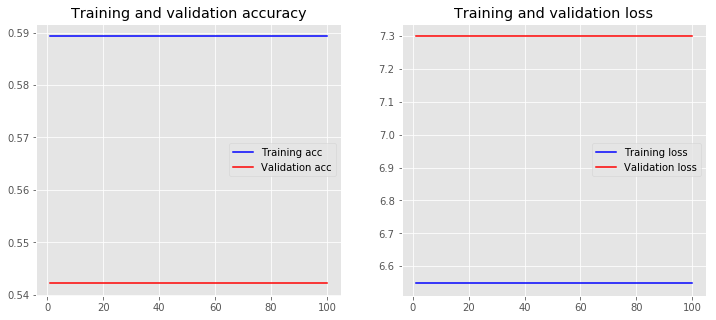

In [46]:
plot_history(history)

# Model 2

In [47]:
from keras.models import Sequential
from keras import layers

#embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=nb_words,
                           output_dim=embedding_dim, 
                           input_length=max_daily_length))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          19066800  
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                3010      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 19,069,821
Trainable params: 19,069,821
Non-trainable params: 0
_________________________________________________________________


In [48]:
history = model.fit(x_train, y_train,
                    epochs=100,
                    verbose=False,
                    validation_data=(x_test, y_test),
                    batch_size=10)

In [49]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.5422


# Model 3

In [50]:
model = Sequential()
embedding_dim = 300
model.add(layers.Embedding(input_dim =nb_words, 
                          output_dim =embedding_dim,
                          weights=[word_embedding_matrix], 
                          input_length=max_daily_length,
                          trainable = False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 300)          19066800  
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                3010      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 19,069,821
Trainable params: 3,021
Non-trainable params: 19,066,800
_________________________________________________________________


In [51]:
history = model.fit(x_train, y_train,
                    epochs=200,
                    verbose=False,
                    validation_data=(x_test, y_test),
                    batch_size=10)

loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.9702
Testing Accuracy:  0.4699


# Model 4

In [60]:
from keras.models import Sequential
from keras import layers

#embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=nb_words,
                           output_dim=embedding_dim, 
                           input_length=max_daily_length))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 300)          19066800  
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 300)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                3010      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 19,069,821
Trainable params: 19,069,821
Non-trainable params: 0
_________________________________________________________________


In [64]:
history = model.fit(x_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(x_test, y_test),
                    batch_size=30)

In [65]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.5893
Testing Accuracy:  0.5422


# Model 5

In [66]:
model = Sequential()
embedding_dim = 300
model.add(layers.Embedding(input_dim =nb_words, 
                          output_dim =embedding_dim,
                          weights=[word_embedding_matrix], 
                          input_length=max_daily_length,
                          trainable = True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 300)          19066800  
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 300)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                3010      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 11        
Total params: 19,069,821
Trainable params: 19,069,821
Non-trainable params: 0
_________________________________________________________________


In [67]:
history = model.fit(x_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(x_test, y_test),
                    batch_size=40)

In [68]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.5422


In [69]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc)+1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

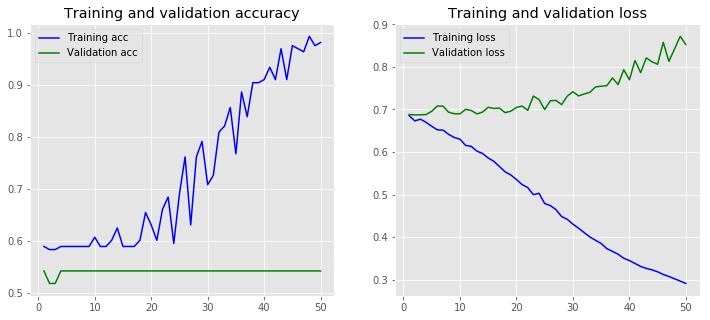

In [70]:
plot_history(history)

#Conclusion:  1 - Data points are restricted to 251, since we are considering 1 year of news and stocks.

#2 - The neural network yields great accuracy with training not great with testing.(But this is due to the less number of data points)

#3 - For any model to perform well we need atleast couple of thousand of rows.

#4 - Since there is no cloud access, the NLP processing is Computation heavy, hence we are restricted to producing a model with just one year of Data.
